In [76]:
import numpy as np
from torch.autograd import Variable
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.autograd as autograd
from torch.utils.data import Dataset
from training_dataset import sequence_loader
from train_utils import save_checkpoint, evaluate_lstm_baseline
import argparse
from lstm_baseline import LSTM
from train import *
from visualize_results import  plot_cost, plot_loss, visualize_sequence
from glob import glob
import json
import os
import sys
from matplotlib import pyplot as plt
import warnings 
warnings.filterwarnings("ignore") 

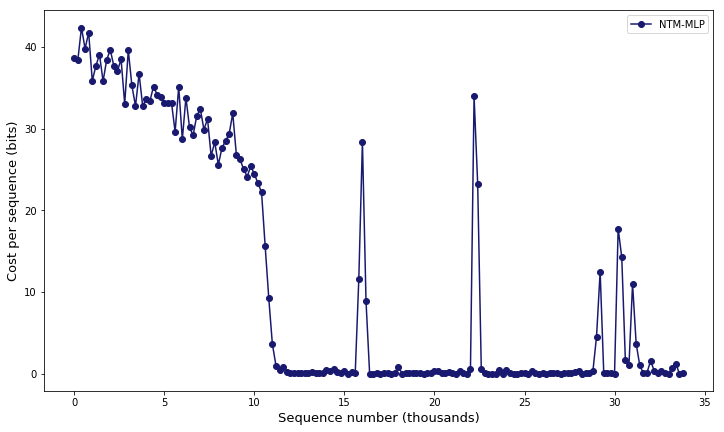

In [717]:
plot_cost(checkpoint, 'NTM-MLP', spacing=200)
plt.show()

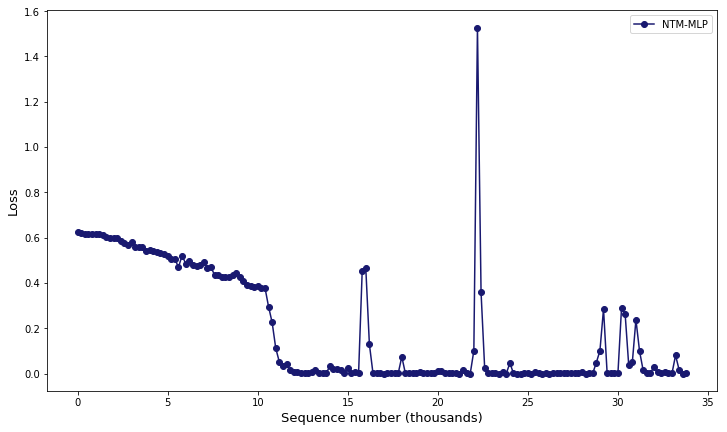

In [719]:
plot_loss(checkpoint, 'NTM-MLP', spacing=200)
plt.show()

In [4]:
from_before = torch.load(cp, map_location=lambda storage, loc: storage)
state_dict = from_before['state_dict']
model = LSTM(9, 100, 1)
model.load_state_dict(state_dict)

In [80]:
evaluate_lstm_baseline(model, 20)

NameError: name 'model' is not defined

In [4]:
class random_binary(Dataset):

    def __init__(self, max_seq_length, num_sequences, vector_dim=8, batch_Size=32, min_seq_length=1):
        '''
        :param max_seq_length: maximum sequence length allowed
        :param num_sequences: number of sequences
        :param vector_dim: dimension of input binary vector
        :param batch_Size: batch size
        '''
        self.max_seq_length = max_seq_length
        self.num_sequences = num_sequences
        self.vector_dim = vector_dim
        self.batch_Size = batch_Size
        self.min_seq_length = min_seq_length

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        vector_end = np.append(np.zeros(self.vector_dim), 1).reshape(self.vector_dim + 1, 1)  # x_{T+1}
        seq_length = np.random.randint(self.min_seq_length, self.max_seq_length)                 # T
        batch = np.ndarray(shape=(self.batch_Size, self.vector_dim + 1, seq_length+1))
        for i in range(self.batch_Size):
            sequence = np.random.binomial(1, 0.5, size=(self.vector_dim, seq_length))  # 8 x T
            sequence = np.append(sequence, np.zeros((1, seq_length)), axis=0)          # Append 0 at the end of each vector
            sequence = np.append(sequence, vector_end, axis=1)                         # Append x_{T+1} at the end of the seq.
            batch[i, :, :] = sequence
        return torch.FloatTensor(batch)

In [466]:
def visualize_sequence(checkpoint, model_type='NTM', cuda=False, seq_len=100):

    if model_type == 'NTM':
        if not cuda:  # load to CPU
            from_before = torch.load(checkpoint, map_location=lambda storage, loc: storage)
            state_dict = from_before['state_dict']
            controller_type = from_before['controller_type']
            num_inputs = from_before['num_inputs']
            num_outputs = from_before['num_outputs']
            controller_size = from_before['controller_size']
            controller_layers = from_before['controller_layers']
            memory_size = from_before['memory_size']
            batch_size = from_before['batch_size']
            memory_feature_size = from_before['memory_feature_size']
            integer_shift = from_before['integer_shift']
            batch_size = 2

            model = NTM(num_inputs=num_inputs, num_outputs=num_outputs, controller_size=controller_size,
                        controller_type=controller_type, controller_layers=controller_layers, memory_size=memory_size,
                        memory_feature_size=memory_feature_size, integer_shift=integer_shift, batch_size=batch_size,
                        use_cuda=cuda)
            model.load_state_dict(state_dict)

            dataset = random_binary(max_seq_length=seq_len, num_sequences=1, vector_dim=8,
                                    batch_Size=batch_size, min_seq_length=seq_len - 1)

            for batch in dataset:
                batch = Variable(batch)
                model.init_headweights()
                model.init_memory()

                if cuda:
                    batch = batch.cuda()
                next_r = model.read_head.create_state(batch_size)
                if controller_type == 'LSTM':
                    lstm_h, lstm_c = model.controller.create_state(batch_size)

                for i in range(batch.size()[2]):
                    x = batch[:, :, i]
                    if controller_type == 'LSTM':
                        _, next_r, lstm_h, lstm_c = model.forward(x=x, r=next_r, lstm_h=lstm_h, lstm_c=lstm_c)
                    elif controller_type == 'MLP':
                        _, next_r = model.forward(x=x, r=next_r)

                # Read output without input
                x = Variable(torch.zeros(batch.size()[0:2]))
                output = Variable(torch.zeros(batch[:, :, :-1].size()))
                if cuda:
                    output = output.cuda()
                for i in range(output.size()[2]):
                    if controller_type == 'LSTM':
                        output[:, :, i], next_r, lstm_h, lstm_c = model.forward(x=x, r=next_r, lstm_h=lstm_h,
                                                                                lstm_c=lstm_c)
                    elif controller_type == 'MLP':
                        output[:, :, i], next_r = model.forward(x=x, r=next_r)

                break

        binary_output = output.clone().data
        binary_output = binary_output > 0.5

        x = batch.data[0].numpy()
        y = output.data[0].numpy()

        # Putting the matrices together for nice display, with empty_rows between the two plots
        fig, ax = plt.subplots(2, 1, sharex=True, figsize=(seq_len / 6, 4))

        ax[0].imshow(x, cmap='binary', interpolation='nearest', aspect='auto')
        ax[0].set_ylabel('Target', rotation=0, labelpad=30, fontsize=13)
        im = ax[1].imshow(y, cmap='binary', interpolation='nearest', aspect='auto')
        ax[1].set_ylabel('Output', rotation=0, labelpad=30, fontsize=13)

        fig.colorbar(im, ax=ax.ravel().tolist())
        for ax_ in ax:
            ax_.set_xticks([])
            ax_.set_yticks([])
        plt.show()


    elif model_type == "LSTM":
        if not cuda:  # load to CPU
            from_before = torch.load(checkpoint, map_location=lambda storage, loc: storage)
            state_dict = from_before['state_dict']
            num_inputs = from_before['num_inputs']
            num_hidden = from_before['hidden_dim']
            num_outputs = from_before['num_outputs']
            batch_size = 2
        model = LSTM(num_inputs, num_hidden)
        model.load_state_dict(state_dict)

        dataset = random_binary(max_seq_length=seq_len, num_sequences=1, vector_dim=8,
                                batch_Size=batch_size, min_seq_length=seq_len - 1)

        for batch in dataset:
            model.init_hidden(batch_size, cuda)
            batch = Variable(torch.FloatTensor(batch))
            if cuda:
                batch = batch.cuda()
            output = Variable(torch.zeros(batch.size()))
            if cuda:
                output = output.cuda()
            for i in range(batch.size()[2]):
                x = batch[:, :, i]
                output[:, :, i] = model.forward(x)
            break

        X = batch.squeeze(0).data.numpy()
        Y = output.squeeze(0).data.numpy()

        # Putting the matrices together for nice display, with empty_rows between the two plots
        fig, ax = plt.subplots(2, 1, sharex=True, figsize=(seq_len/6, 4))

        empty_rows = 2
        data = np.ones((X.shape[1] + Y.shape[1] + empty_rows, X.shape[2])) * 0.5
        x = X[0]
        y = Y[0]

        ax[0].imshow(x, cmap='binary', interpolation='nearest', aspect='auto')
        ax[0].set_ylabel('Target', rotation=0, labelpad=30, fontsize=13)
        im = ax[1].imshow(y, cmap='binary', interpolation='nearest', aspect='auto')
        ax[1].set_ylabel('Output', rotation=0, labelpad=30, fontsize=13)

        fig.colorbar(im, ax=ax.ravel().tolist())
        for ax_ in ax:
            ax_.set_xticks([])
            ax_.set_yticks([])
        plt.show()

In [769]:
def visualize_sequence_alejandro(checkpoint, model_type='NTM', cuda=False, seq_len=100):

    if model_type == 'NTM':
        from_before = torch.load(checkpoint, map_location=lambda storage, loc: storage)
        state_dict = from_before['state_dict']
        controller_type = from_before['controller_type']
        num_inputs = from_before['num_inputs']
        num_outputs = from_before['num_outputs']
        controller_size = from_before['controller_size']
        controller_layers = from_before['controller_layers']
        memory_size = from_before['memory_size']
        batch_size = from_before['batch_size']
        memory_feature_size = from_before['memory_feature_size']
        integer_shift = from_before['integer_shift']
        batch_size = 1

        model = NTM(num_inputs=num_inputs, num_outputs=num_outputs, controller_size=controller_size,
                    controller_type=controller_type, controller_layers=controller_layers, memory_size=memory_size,
                    memory_feature_size=memory_feature_size, integer_shift=integer_shift, batch_size=batch_size,
                    use_cuda=cuda)
        model.load_state_dict(state_dict)

        dataloader = sequence_loader(num_batches=1, batch_size=batch_size, min_length=seq_len - 1, max_length=seq_len)
        x, y, dummy = next(dataloader)

        input_seq_length = x.shape[0]
        output_seq_length = y.shape[0]
        output = Variable(torch.zeros(y.size()))

        x = x.view(batch_size, 9, input_seq_length)
        y = y.view(batch_size, 8, output_seq_length)
        output = output.view(y.size())

        model.init_headweights()
        model.init_memory()

        next_r = model.read_head.create_state(batch_size)
        if controller_type == 'LSTM':
            lstm_h, lstm_c = model.controller.create_state(batch_size)

        # Forward pass
        for i in range(input_seq_length):
            x_ = x[:, :, i]
            if controller_type == 'LSTM':
                _, next_r, lstm_h, lstm_c = model.forward(x=x_, r=next_r, lstm_h=lstm_h, lstm_c=lstm_c)
            elif controller_type == 'MLP':
                _, next_r = model.forward(x=x_, r=next_r)

        x_ = Variable(torch.zeros(x.size()[0:2])) + 0.5
        output = Variable(torch.zeros(y.size()))

        # Get output
        for i in range(output_seq_length):
            if controller_type == 'LSTM':
                output[:, :, i], next_r, lstm_h, lstm_c = model.forward(x=x_, r=next_r, lstm_h=lstm_h, lstm_c=lstm_c)
            elif controller_type == 'MLP':
                output[:, :, i], next_r = model.forward(x=x_, r=next_r)

        binary_output = output.clone().data
        binary_output = binary_output > 0.5

        fig, ax = plt.subplots(2, 1, sharex=True, figsize=(seq_len / 6, 4))
        target_np = y.data.numpy().squeeze()
        output_np = output.data.numpy().squeeze()

        ax[0].imshow(target_np, cmap='binary', interpolation='nearest', aspect='auto')
        ax[0].set_ylabel('Target', rotation=0, labelpad=30, fontsize=13)
        im = ax[1].imshow(output_np, cmap='binary', interpolation='nearest', aspect='auto')
        ax[1].set_ylabel('Output', rotation=0, labelpad=30, fontsize=13)

        fig.colorbar(im, ax=ax.ravel().tolist())
        for ax_ in ax:
            ax_.set_xticks([])
            ax_.set_yticks([])
        plt.show()
        
    elif model_type == "LSTM":
        if not cuda:  # load to CPU
            from_before = torch.load(checkpoint, map_location=lambda storage, loc: storage)
            state_dict = from_before['state_dict']
            num_inputs = from_before['num_inputs']
            hidden_dim = from_before['hidden_dim']
            num_layers = from_before['num_layers']
            num_outputs = from_before['num_outputs']
            batch_size = 1
        model = LSTM(num_inputs, hidden_dim, num_layers)
        model.load_state_dict(state_dict)
        model.init_hidden(batch_size, cuda)
        
        dataloader = sequence_loader(num_batches=1, batch_size=batch_size, min_length=seq_len - 1, max_length=seq_len)
        x, y, dummy = next(dataloader)

        model.forward(x)

        output = model.forward(dummy)

        fig, ax = plt.subplots(2, 1, sharex=True, figsize=(seq_len / 6, 4))
        target_np = x.data.numpy().T.squeeze()
        output_np = output.data.numpy().T.squeeze()

        ax[0].imshow(target_np[:-1, :], cmap='binary', aspect='auto')
        ax[0].set_ylabel('Target', rotation=0, labelpad=30, fontsize=13)
        im = ax[1].imshow(output_np, cmap='binary', interpolation='nearest', aspect='auto')
        ax[1].set_ylabel('Output', rotation=0, labelpad=30, fontsize=13)

        fig.colorbar(im, ax=ax.ravel().tolist())
        for ax_ in ax:
            ax_.set_xticks([])
            ax_.set_yticks([])
        plt.show()

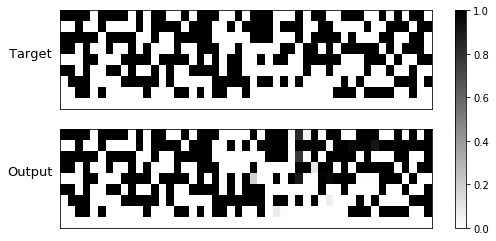

In [790]:
# NTM-LSTM -- Roger
checkpoint = '/Users/alejandroposada/Downloads/IFT6135-A3-roger/checkpoints/ntm/copy-batch-173200.0--LSTM.model'
checkpoint = 'checkpoints/clustercopy-batch-87000.0--LSTM.model'
visualize_sequence(checkpoint, model_type='NTM', cuda=False, seq_len=50)

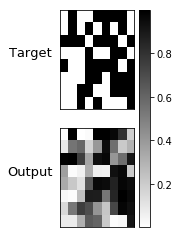

In [775]:
# NTM-LSTM -- Alejandro
checkpoint = 'checkpoints/ntm/copy-batch-168000.0--LSTM.model'
visualize_sequence_alejandro(checkpoint, model_type='NTM', cuda=False, seq_len=10)

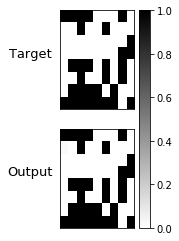

In [797]:
checkpoint = 'checkpoints/lstm/copy-batch-1000000.0.model'
visualize_sequence_alejandro(checkpoint, model_type='LSTM', cuda=False, seq_len=10)

In [ ]:
def evaluate(model, testset, batch_size, controller_type, cuda, memory_feature_size):

    count = 0  # Ugly, I know...
    total_cost = 0
    for batch in testset:
        batch = Variable(batch)
        model.init_headweights()
        model.init_memory()

        if cuda:
            batch = batch.cuda()
        next_r = model.read_head.create_state(batch_size)
        if controller_type == 'LSTM':
            lstm_h, lstm_c = model.controller.create_state(batch_size)

        for i in range(batch.size()[2]):
            x = batch[:, :, i]
            if controller_type == 'LSTM':
                _, next_r, lstm_h, lstm_c = model.forward(x=x, r=next_r, lstm_h=lstm_h, lstm_c=lstm_c)
            elif controller_type == 'MLP':
                _, next_r = model.forward(x=x, r=next_r)

        # Read output without input
        x = Variable(torch.zeros(batch.size()[0:2]))
        output = Variable(torch.zeros(batch[:, :, :-1].size()))
        if cuda:
            output = output.cuda()
        for i in range(output.size()[2]):
            if controller_type == 'LSTM':
                output[:, :, i], next_r, lstm_h, lstm_c = model.forward(x=x, r=next_r, lstm_h=lstm_h, lstm_c=lstm_c)
            elif controller_type == 'MLP':
                output[:, :, i], next_r = model.forward(x=x, r=next_r)

        # The cost is the number of error bits per sequence
        binary_output = output.clone().data
        binary_output = binary_output > 0.5
        # binary_output.apply_(lambda y: 0 if y < 0.5 else 1)
        cost = torch.sum(torch.abs(binary_output.float() - batch.data[:, :, :-1]))
        total_cost += cost / batch_size

        count += 1
        if count >= 4:
            break

    return cost/(count-1), binary_output, batch

In [258]:
checkpoint = 'checkpoints/ntm/copy-batch-80000.0--MLP.model'

from_before = torch.load(checkpoint, map_location=lambda storage, loc: storage)
state_dict = from_before['state_dict']
controller_type = from_before['controller_type']
num_inputs = from_before['num_inputs']
num_outputs = from_before['num_outputs']
controller_size = from_before['controller_size']
controller_layers = from_before['controller_layers']
memory_size = from_before['memory_size']
batch_size = from_before['batch_size']
memory_feature_size = from_before['memory_feature_size']
integer_shift = from_before['integer_shift']
batch_size = 2

model = NTM(num_inputs=num_inputs, num_outputs=num_outputs, controller_size=controller_size,
                        controller_type=controller_type, controller_layers=controller_layers, memory_size=memory_size,
                        memory_feature_size=memory_feature_size, integer_shift=integer_shift, batch_size=batch_size,
                        use_cuda=False)
model.load_state_dict(state_dict)

seq_len = 10
dataset = random_binary(max_seq_length=seq_len, num_sequences=1, vector_dim=8,
                                batch_Size=batch_size, min_seq_length=seq_len - 1)
cost, b, c= evaluate(model, dataset, batch_size, 'MLP', False, memory_feature_size)

In [324]:
lc = '/Users/alejandroposada/Desktop/pytorch-ntm-master/checkpoints/copy-task-1000-batch-9000.json'

with open(lc) as json_data:
    d = json.load(json_data)

model = torch.load('/Users/alejandroposada/Desktop/pytorch-ntm-master/checkpoints/copy-task-1000-batch-9000.model')

model = EncapsulatedNTM(self.params.sequence_width + 1, self.params.sequence_width,
                              self.params.controller_size, self.params.controller_layers,
                              self.params.num_heads,
                              self.params.memory_n, self.params.memory_m)

In [349]:
print(model['ntm.heads.0.fc_read.weight'])
print(model['ntm.heads.1.fc_write.weight'])


-0.1530  0.2779 -0.2013  ...  -0.1355  0.0763  0.0950
-0.1647 -0.0275  0.2150  ...  -0.1748 -0.0136 -0.0812
 0.2168  0.2872  0.1001  ...  -0.0200  0.3053 -0.1680
          ...             ⋱             ...          
 0.1715  0.0123  0.0787  ...   0.3913 -0.3354 -0.0240
 0.0141  0.1892 -0.0532  ...  -0.1506  0.1923  0.1581
-0.3613  0.5921 -0.0994  ...   0.1922  0.2562  0.2734
[torch.FloatTensor of size 26x100]


-0.1926  0.1412  0.2932  ...  -0.1741 -0.0366 -0.1866
 0.0435 -0.0543 -0.0662  ...   0.1831  0.1510 -0.0980
 0.1235 -0.0062  0.1890  ...   0.0334 -0.1603 -0.1601
          ...             ⋱             ...          
 0.0930 -0.1991 -0.1987  ...   0.0012  0.5700  0.1085
-0.1723 -0.1329  0.2072  ...  -0.3157 -0.4130  0.2297
-0.0844 -0.4420  0.0353  ...  -0.2387  0.0020 -0.3291
[torch.FloatTensor of size 66x100]



In [331]:
for k in model.keys():
    print(k, '-----', model[k].shape)

ntm.read0_bias ----- torch.Size([1, 20])
ntm.controller.lstm_h_bias ----- torch.Size([1, 1, 100])
ntm.controller.lstm_c_bias ----- torch.Size([1, 1, 100])
ntm.controller.lstm.weight_ih_l0 ----- torch.Size([400, 29])
ntm.controller.lstm.weight_hh_l0 ----- torch.Size([400, 100])
ntm.controller.lstm.bias_ih_l0 ----- torch.Size([400])
ntm.controller.lstm.bias_hh_l0 ----- torch.Size([400])
ntm.memory.mem_bias ----- torch.Size([128, 20])
ntm.heads.0.memory.mem_bias ----- torch.Size([128, 20])
ntm.heads.0.fc_read.weight ----- torch.Size([26, 100])
ntm.heads.0.fc_read.bias ----- torch.Size([26])
ntm.heads.1.memory.mem_bias ----- torch.Size([128, 20])
ntm.heads.1.fc_write.weight ----- torch.Size([66, 100])
ntm.heads.1.fc_write.bias ----- torch.Size([66])
ntm.fc.weight ----- torch.Size([8, 120])
ntm.fc.bias ----- torch.Size([8])
memory.mem_bias ----- torch.Size([128, 20])


In [323]:
dl = dataloader(1, 1, 8, 1, 20)

i, x, y = next(dl)

model.net

AttributeError: 'collections.OrderedDict' object has no attribute 'net'

In [291]:
import random
def dataloader(num_batches,
               batch_size,
               seq_width,
               min_len,
               max_len):
    """Generator of random sequences for the copy task.

    Creates random batches of "bits" sequences.

    All the sequences within each batch have the same length.
    The length is [`min_len`, `max_len`]

    :param num_batches: Total number of batches to generate.
    :param seq_width: The width of each item in the sequence.
    :param batch_size: Batch size.
    :param min_len: Sequence minimum length.
    :param max_len: Sequence maximum length.

    NOTE: The input width is `seq_width + 1`, the additional input
    contain the delimiter.
    """
    for batch_num in range(num_batches):

        # All batches have the same sequence length
        seq_len = random.randint(min_len, max_len)
        seq = np.random.binomial(1, 0.5, (seq_len, batch_size, seq_width))
        seq = Variable(torch.from_numpy(seq))

        # The input includes an additional channel used for the delimiter
        inp = Variable(torch.zeros(seq_len + 1, batch_size, seq_width + 1))
        inp[:seq_len, :, :seq_width] = seq
        inp[seq_len, :, seq_width] = 1.0 # delimiter in our control channel
        outp = seq.clone()

        yield batch_num+1, inp.float(), outp.float()

In [300]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [321]:
total_params = 0
for k in model.keys():
    total_params += model[k].numel()
print(total_params)
    

73120


In [322]:
total_params = 0
for p in ntm.parameters():
    total_params += p.numel()
print(total_params)
    

65561


In [ ]:
def visualize_sequence_alejandro(checkpoint, model_type='NTM', cuda=False, seq_len=100):

    if model_type == 'NTM':
        if not cuda:  # load to CPU
            from_before = torch.load(checkpoint, map_location=lambda storage, loc: storage)
            state_dict = from_before['state_dict']
            controller_type = from_before['controller_type']
            num_inputs = from_before['num_inputs']
            num_outputs = from_before['num_outputs']
            controller_size = from_before['controller_size']
            controller_layers = from_before['controller_layers']
            memory_size = from_before['memory_size']
            batch_size = from_before['batch_size']
            memory_feature_size = from_before['memory_feature_size']
            integer_shift = from_before['integer_shift']
            batch_size = 1

            model = NTM(num_inputs=num_inputs, num_outputs=num_outputs, controller_size=controller_size,
                        controller_type=controller_type, controller_layers=controller_layers, memory_size=memory_size,
                        memory_feature_size=memory_feature_size, integer_shift=integer_shift, batch_size=batch_size,
                        use_cuda=cuda)
            model.load_state_dict(state_dict)

            dataset = random_binary(max_seq_length=seq_len, num_sequences=1, vector_dim=8,
                                    batch_Size=batch_size, min_seq_length=seq_len - 1)

            for batch in dataset:
                batch = Variable(batch)
                model.init_headweights()
                model.init_memory()

                if cuda:
                    batch = batch.cuda()
                next_r = model.read_head.create_state(batch_size)
                if controller_type == 'LSTM':
                    lstm_h, lstm_c = model.controller.create_state(batch_size)

                for i in range(batch.size()[2]):
                    x = batch[:, :, i]
                    if controller_type == 'LSTM':
                        _, next_r, lstm_h, lstm_c = model.forward(x=x, r=next_r, lstm_h=lstm_h, lstm_c=lstm_c)
                    elif controller_type == 'MLP':
                        _, next_r = model.forward(x=x, r=next_r)

                # Read output without input
                x = Variable(torch.zeros(batch.size()[0:2])) + 0.5
                output = Variable(torch.zeros(batch[:, :-1, :-1].size()))
                if cuda:
                    output = output.cuda()
                for i in range(output.size()[2]):
                    if controller_type == 'LSTM':
                        a, next_r, lstm_h, lstm_c = model(x=x, r=next_r, lstm_h=lstm_h, lstm_c=lstm_c)
                        output[:, :, i] = a[:, :]    # TODO
                    elif controller_type == 'MLP':
                        output[:, :, i], next_r = model.forward(x=x, r=next_r)

                break

        binary_output = output.clone().data
        binary_output = binary_output > 0.5

        x = batch.data[0].numpy()
        y = output.data[0].numpy()

        # Putting the matrices together for nice display, with empty_rows between the two plots
        fig, ax = plt.subplots(2, 1, sharex=True, figsize=(seq_len / 6, 4))

        ax[0].imshow(x, cmap='binary', interpolation='nearest', aspect='auto')
        ax[0].set_ylabel('Target', rotation=0, labelpad=30, fontsize=13)
        im = ax[1].imshow(y, cmap='binary', interpolation='nearest', aspect='auto')
        ax[1].set_ylabel('Output', rotation=0, labelpad=30, fontsize=13)

        fig.colorbar(im, ax=ax.ravel().tolist())
        for ax_ in ax:
            ax_.set_xticks([])
            ax_.set_yticks([])
        plt.show()
        
    elif model_type == "LSTM":
        if not cuda:  # load to CPU
            from_before = torch.load(checkpoint, map_location=lambda storage, loc: storage)
            state_dict = from_before['state_dict']
            num_inputs = from_before['num_inputs']
            hidden_dim = from_before['hidden_dim']
            num_layers = from_before['num_layers']
            num_outputs = from_before['num_outputs']
            batch_size = 1
        model = LSTM(num_inputs, hidden_dim, num_layers)
        model.load_state_dict(state_dict)
        model.init_hidden(batch_size, cuda)
        
        dataloader = sequence_loader(num_batches=1, batch_size=batch_size, min_length=seq_len - 1, max_length=seq_len)
        x, y, dummy = next(dataloader)

        model.forward(x)

        output = model.forward(dummy)

        fig, ax = plt.subplots(2, 1, sharex=True, figsize=(seq_len / 6, 4))
        target_np = x.data.numpy().T.squeeze()
        output_np = output.data.numpy().T.squeeze()

        ax[0].imshow(target_np[:-1, :], cmap='binary', aspect='auto')
        ax[0].set_ylabel('Target', rotation=0, labelpad=30, fontsize=13)
        im = ax[1].imshow(output_np, cmap='binary', interpolation='nearest', aspect='auto')
        ax[1].set_ylabel('Output', rotation=0, labelpad=30, fontsize=13)

        fig.colorbar(im, ax=ax.ravel().tolist())
        for ax_ in ax:
            ax_.set_xticks([])
            ax_.set_yticks([])
        plt.show()